<a href="https://colab.research.google.com/github/katybohanan/5542-NN-Models/blob/main/California_Housing_Classification_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install required libraries (if not already installed)
!pip install torch torchvision scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 846.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [43]:
# Cell 2: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.datasets import load_iris

In [5]:
# Cell 3: Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [34]:
# Cell 4: Dataset Preparation
## 4.1 Load and preprocess the Diabetes Dataset
housing = fetch_california_housing()
X_housing = housing.data
y_housing = housing.target
print("Initial data shape:", X_housing.shape, y_housing.shape)

# Convert the target to binary for classification
threshold = np.median(y_housing)
y_housing_binary = (y_housing > threshold).astype(int)
print("Threshold for classification:", threshold)
print("Binary target values (first 10):", y_housing_binary[:10])

# Train-test split for regression and classification
data_split = train_test_split(
    X_housing, y_housing, y_housing_binary, test_size=0.2, random_state=42
)
X_train, X_test, y_train, y_test, y_train_binary, y_test_binary = data_split
print("Train/Test split shapes:", X_train.shape, X_test.shape)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Sample standardized features (first 5 rows):", X_train[:5])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)
y_train_binary_tensor = torch.tensor(y_train_binary, dtype=torch.float32).view(-1, 1).to(device)
y_test_binary_tensor = torch.tensor(y_test_binary, dtype=torch.float32).view(-1, 1).to(device)

Initial data shape: (20640, 8) (20640,)
Threshold for classification: 1.797
Binary target values (first 10): [1 1 1 1 1 1 1 1 1 1]
Train/Test split shapes: (16512, 8) (4128, 8)
Sample standardized features (first 5 rows): [[-0.326196    0.34849025 -0.17491646 -0.20836543  0.76827628  0.05137609
  -1.3728112   1.27258656]
 [-0.03584338  1.61811813 -0.40283542 -0.12853018 -0.09890135 -0.11736222
  -0.87669601  0.70916212]
 [ 0.14470145 -1.95271028  0.08821601 -0.25753771 -0.44981806 -0.03227969
  -0.46014647 -0.44760309]
 [-1.01786438  0.58654547 -0.60001532 -0.14515634 -0.00743434  0.07750687
  -1.38217186  1.23269811]
 [-0.17148831  1.14200767  0.3490073   0.08662432 -0.48587717 -0.06883176
   0.5320839  -0.10855122]]


In [35]:
# Cell 5: Define the Feedforward Neural Network for Regression and Classification
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, classification=False):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        if classification:
            x = self.sigmoid(x)
        return x

# Initialize models
model_regression = FeedforwardNN(X_train.shape[1], 1).to(device)
model_classification = FeedforwardNN(X_train.shape[1], 1).to(device)
print("Models initialized.")

Models initialized.


In [36]:
# Cell 6: Define Loss Functions and Optimizers
criterion_regression = nn.MSELoss()
criterion_classification = nn.BCELoss()
optimizer_regression = optim.Adam(model_regression.parameters(), lr=0.01)
optimizer_classification = optim.Adam(model_classification.parameters(), lr=0.01)
print("Loss functions and optimizers defined.")

Loss functions and optimizers defined.


In [40]:
# Cell 7: Train the Models
def train_model(model, optimizer, X_train, y_train, criterion, epochs=100, classification=False):
    for epoch in range(epochs):
        model.train()
        inputs = X_train
        targets = y_train

        # Forward pass
        predictions = model(inputs, classification=classification)
        loss = criterion(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Train the Regression model
print("Training Regression Model")
train_model(model_regression, optimizer_regression, X_train_tensor, y_train_tensor, criterion_regression)

# Train the Classification model
print("Training Classification Model")
train_model(model_classification, optimizer_classification, X_train_tensor, y_train_binary_tensor, criterion_classification, classification=True)

Training Regression Model
Epoch 10/100, Loss: 0.3307
Epoch 20/100, Loss: 0.3258
Epoch 30/100, Loss: 0.3211
Epoch 40/100, Loss: 0.3167
Epoch 50/100, Loss: 0.3125
Epoch 60/100, Loss: 0.3086
Epoch 70/100, Loss: 0.3047
Epoch 80/100, Loss: 0.3010
Epoch 90/100, Loss: 0.2974
Epoch 100/100, Loss: 0.2936
Training Classification Model
Epoch 10/100, Loss: 0.2823
Epoch 20/100, Loss: 0.2796
Epoch 30/100, Loss: 0.2804
Epoch 40/100, Loss: 0.2772
Epoch 50/100, Loss: 0.2739
Epoch 60/100, Loss: 0.2722
Epoch 70/100, Loss: 0.2704
Epoch 80/100, Loss: 0.2734
Epoch 90/100, Loss: 0.2691
Epoch 100/100, Loss: 0.2670


Regression predictions (first 5): [0.58001465 1.3883282  4.6706686  2.6369486  3.1330748 ]
Regression Model - MSE: 0.3103, R-squared: 0.7632
Classification predictions (first 5): [False False  True  True  True]
Classification Model - Accuracy: 0.8774
Classification Model - Precision: 0.8845
Classification Model - Recall: 0.8664
Classification Model - F1 Score: 0.8754


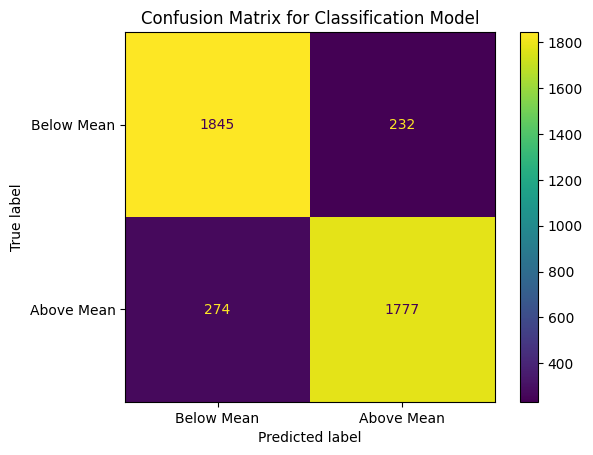

In [47]:
# Cell 8: Evaluate the Models
def evaluate_model_regression(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        mse = mean_squared_error(y_test.cpu().numpy(), predictions)
        r2 = r2_score(y_test.cpu().numpy(), predictions)
        print("Regression predictions (first 5):", predictions[:5].flatten())
    return mse, r2

def evaluate_model_classification(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test, classification=True).cpu().numpy() > 0.5
        accuracy = accuracy_score(y_test.cpu().numpy(), predictions)
        precision = precision_score(y_test.cpu().numpy(), predictions)
        recall = recall_score(y_test.cpu().numpy(), predictions)
        f1 = f1_score(y_test.cpu().numpy(), predictions)
        cm = confusion_matrix(y_test.cpu().numpy(), predictions)
        print("Classification predictions (first 5):", predictions[:5].flatten())
    return accuracy, precision, recall, f1, cm

# Evaluate the Regression model
mse_d, r2_d = evaluate_model_regression(model_regression, X_test_tensor, y_test_tensor)
print(f"Regression Model - MSE: {mse_d:.4f}, R-squared: {r2_d:.4f}")

# Evaluate the Classification model
accuracy_d, precision_d, recall_d, f1_d, cm_d = evaluate_model_classification(model_classification, X_test_tensor, y_test_binary_tensor)
print(f"Classification Model - Accuracy: {accuracy_d:.4f}")
print(f"Classification Model - Precision: {precision_d:.4f}")
print(f"Classification Model - Recall: {recall_d:.4f}")
print(f"Classification Model - F1 Score: {f1_d:.4f}")

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=["Below Mean", "Above Mean"]).plot()
plt.title("Confusion Matrix for Classification Model")
plt.show()

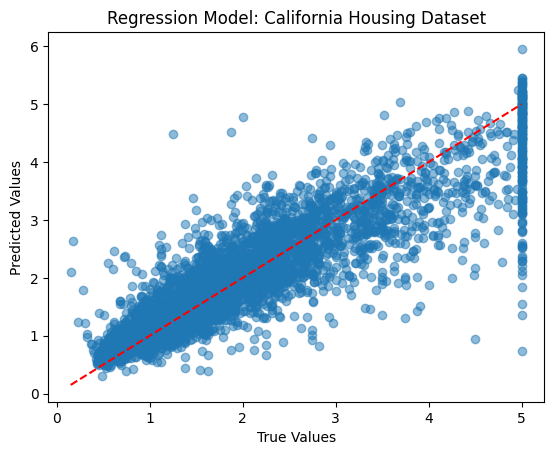

In [42]:
# Cell 9: Visualize the Results
def plot_results_regression(y_test, predictions, title):
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()

# Visualize results for the Regression model
with torch.no_grad():
    predictions = model_regression(X_test_tensor).cpu().numpy()
    plot_results_regression(y_test_tensor.cpu().numpy(), predictions, "Regression Model: California Housing Dataset")